In [ ]:
pip install pyspark

     |████████████████████████████████| 212.4MB 57kB/s 
     |████████████████████████████████| 204kB 20.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=bb98623d0ebf9cbf846c4397d1e2c63026a8d07997e7060f85ca97c8ef559a88
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [ ]:
# handyspark
!pip install handyspark

In [ ]:
from handyspark import *

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import max as sparkMax
from pyspark.sql.functions import to_date
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col,isnan, when, count

import pandas as pd
from sklearn import datasets
import numpy as np

from pyspark.sql.functions import isnan, when, count, col

import matplotlib.pyplot as plt

from pyspark.sql.functions import year, month, dayofmonth, hour
import datetime
from pandas import Series, DataFrame
from textblob import TextBlob


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkByExamples.com').master("local[1]").getOrCreate()
sparkContext=spark.sparkContext

#create a Spark dataframe
df = spark.read.options(header='True', inferSchema='True', delimiter=';') \
  .csv("/content/gdrive/MyDrive/BigData_Tweets/tweets.csv")


In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
# Display the shape
print((df.count(), len(df.columns)))

(40152515, 9)


In [ ]:
# Get a summary of null values
from pyspark.sql.functions import col,isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---+--------+--------+--------+---------+--------+--------+--------+--------+
| id|    user|fullname|     url|timestamp| replies|   likes|retweets|    text|
+---+--------+--------+--------+---------+--------+--------+--------+--------+
|241|22830824|23174141|36862014| 23256898|23258305|23258743|23259423|23260368|
+---+--------+--------+--------+---------+--------+--------+--------+--------+



In [ ]:
# drop the url column
df_clean = df.drop("url")

In [ ]:
print((df_clean.count(), len(df_clean.columns)))

(40152515, 8)


In [ ]:
# drop null values in rows
df_clean = df_clean.dropna(how='any')

In [ ]:
print((df_clean.count(), len(df_clean.columns)))

(16892592, 8)


In [ ]:
df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]
   ).show()

+---+----+--------+---------+-------+-----+--------+----+
| id|user|fullname|timestamp|replies|likes|retweets|text|
+---+----+--------+---------+-------+-----+--------+----+
|  0|   0|     193|        0|      0|    0|       0| 721|
+---+----+--------+---------+-------+-----+--------+----+



In [ ]:
# Show Duplicate rows

df_clean_duplicates = df_clean.groupBy(df_clean.columns).count().filter("count > 1")
df_clean_duplicates.show()
print((df_clean_duplicates.count(), len(df_clean_duplicates.columns)))

+--------------------+-----+--------+--------------------+--------------------+--------------------+--------+--------------------+-----+
|                  id| user|fullname|           timestamp|             replies|               likes|retweets|                text|count|
+--------------------+-----+--------+--------------------+--------------------+--------------------+--------+--------------------+-----+
|23 #VentureCapita...|  &gt|     &gt|                 &gt|                 &gt| #Startups #FinTe...|     &gt|                 &gt|    8|
|Landscape of #Bit...|  &gt|     &gt|                 &gt|                 &gt| #fintech #smartc...|     &gt|                 &gt|    2|
|#Bitcoin led the ...|  &gt|     &gt|                 &gt|                 &gt| #cryptocurrencie...|     &gt|                 &gt|    2|
|please hit the li...|  &gt|     &gt| https://t.co/Hhk...|                 &lt|                 &lt|     &lt|                   "|    5|
|99% of all #bitco...|  &gt|     &gt|    

In [ ]:
import pyspark.sql.functions as F
print(df_clean_duplicates.agg(F.sum('count')).collect()[0][0])

2924


In [ ]:
# Drop the duplicates

df_clean = df_clean.dropDuplicates()
print((df_clean.count(), len(df_clean.columns)))

(16889703, 8)


In [ ]:
# Show Duplicate rows

df_clean_duplicates = df_clean.groupBy(df_clean.columns).count().filter("count > 1")
df_clean_duplicates.show()
print((df_clean_duplicates.count(), len(df_clean_duplicates.columns)))

+---+----+--------+---------+-------+-----+--------+----+-----+
| id|user|fullname|timestamp|replies|likes|retweets|text|count|
+---+----+--------+---------+-------+-----+--------+----+-----+
+---+----+--------+---------+-------+-----+--------+----+-----+

(0, 9)


In [ ]:
# cast the likes and retweets columns to integers
df_clean = df_clean.withColumn("likes", df_clean["likes"].cast("int"))
df_clean = df_clean.withColumn("retweets", df_clean["retweets"].cast("int"))

In [ ]:
df_clean.dtypes

[('id', 'string'),
 ('user', 'string'),
 ('fullname', 'string'),
 ('timestamp', 'string'),
 ('replies', 'string'),
 ('likes', 'int'),
 ('retweets', 'int'),
 ('text', 'string')]

In [ ]:
df_date = df_clean.withColumn("timestamp", df_clean["timestamp"].cast("timestamp"))
df_date.show()

+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+
|                 id|           user|                fullname|          timestamp|replies|likes|retweets|                                 text|
+-------------------+---------------+------------------------+-------------------+-------+-----+--------+-------------------------------------+
|1132977276738387969|ernadettebond35|                  さくら|2019-05-27 11:50:07|      0|    0|       0|                                  BTC|
|1132979365095104513| rakesh_abhinav|          Abhinav Rakesh|2019-05-27 11:58:25|      0|    0|       0|                 Why Analysts are ...|
|1132979390961344514|        zzetkl5|          Cem’in 6.hissi|2019-05-27 11:58:31|      0|    0|       0|                 #pazartesi #Oğuz ...|
|1132979878586982400|     LaMarkazia|    La Markazia | لام...|2019-05-27 12:00:27|      0|    0|       0|                 أخر أسعار العملات

In [ ]:
df_date.dtypes

[('id', 'string'),
 ('user', 'string'),
 ('fullname', 'string'),
 ('timestamp', 'timestamp'),
 ('replies', 'string'),
 ('likes', 'int'),
 ('retweets', 'int'),
 ('text', 'string')]

In [ ]:
df_data = df_date.orderBy(col('timestamp').desc())
df_data.show()

+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+
|                 id|           user|            fullname|          timestamp|replies|likes|retweets|                                 text|
+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+
|1198266442673733633|Adekunl95628158|     Adekunle Daniel|2019-11-23 15:45:57|      0|    0|       0|                                @btc |
|1198266441293860864|       torusJKL|Gal Buki ($torusJKL)|2019-11-23 15:45:56|      0|    0|       0|                 Register now for ...|
|1198266433941233664|        Vizique|             Vizique|2019-11-23 15:45:55|      0|    0|       0|                 Bitcoin Suisse Ce...|
|1198266433471471617|  digital_mine_|digital mine ⚡🤖?...|2019-11-23 15:45:55|      0|    0|       0|                 Daily profit for ...|
|1198266427666505730|

In [ ]:
df_data.tail(10)

[Row(id='&gt', user='&gt', fullname='&gt', timestamp=None, replies='&gt', likes=None, retweets=None, text=' https://t.co/bSrAGb71Go"'),
 Row(id='&gt', user='&gt', fullname='&gt', timestamp=None, replies='&gt', likes=None, retweets=None, text=' https://t.co/I2gATrY4wT"'),
 Row(id='&lt', user='div id=""cashgames-iframe-container"" style=""border-radius: 20px', fullname=' width: fit-content', timestamp=None, replies='""&gt', likes=None, retweets=None, text='"" width=""950"" height=""600""&gt'),
 Row(id='&lt', user='iframe src=""https://t.co/IFGPIGMfaA"" width=""480"" height=""365"" frameBorder=""0"" class=""giphy-embed"" allowFullScreen&gt', fullname='&lt', timestamp=None, replies='p&gt', likes=None, retweets=None, text='via GIPHY&lt'),
 Row(id='&gt', user='&gt', fullname='&gt', timestamp=None, replies='&gt', likes=None, retweets=None, text=' https://t.co/dQ6Gui3dOq"'),
 Row(id='----&gt', user='&gt', fullname='&gt', timestamp=None, replies='&lt', likes=None, retweets=None, text='----'),
 

In [ ]:
df_data.agg({'timestamp':'min'}).show()

+-------------------+
|     min(timestamp)|
+-------------------+
|2007-04-19 07:14:38|
+-------------------+



In [ ]:
import datetime
from pyspark.sql.functions import year, month, dayofmonth

df_data.select(year("timestamp").alias('year')).show()

+----+
|year|
+----+
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
|2019|
+----+
only showing top 20 rows



In [ ]:
df_data = df_data.where(year("timestamp")>2016)
df_data.show()

+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+
|                 id|           user|            fullname|          timestamp|replies|likes|retweets|                                 text|
+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+
|1198266442673733633|Adekunl95628158|     Adekunle Daniel|2019-11-23 15:45:57|      0|    0|       0|                                @btc |
|1198266441293860864|       torusJKL|Gal Buki ($torusJKL)|2019-11-23 15:45:56|      0|    0|       0|                 Register now for ...|
|1198266433941233664|        Vizique|             Vizique|2019-11-23 15:45:55|      0|    0|       0|                 Bitcoin Suisse Ce...|
|1198266433471471617|  digital_mine_|digital mine ⚡🤖?...|2019-11-23 15:45:55|      0|    0|       0|                 Daily profit for ...|
|1198266427666505730|

In [ ]:
df_data.agg({'timestamp':'min'}).show()

+-------------------+
|     min(timestamp)|
+-------------------+
|2017-01-01 00:00:03|
+-------------------+



In [ ]:
print((df_data.count(), len(df_data.columns)))

(15996363, 8)


In [ ]:
df_data.rdd.getNumPartitions

<bound method RDD.getNumPartitions of MapPartitionsRDD[91] at javaToPython at NativeMethodAccessorImpl.java:0>

In [ ]:
df_data.write.csv("/content/gdrive/MyDrive/BigData_Tweets/cleaned_tweets.csv")

In [ ]:
df_data.repartition(1).write.option("header", "true").csv("/content/gdrive/MyDrive/BigData_Tweets/cleaned_tweets_file1.csv")


# **Analytic** **1**

+----+------+
|hour|_Count|
+----+------+
|  16|832123|
|  14|821375|
|  15|811240|
|  13|807122|
|  12|780134|
|  17|775722|
|  18|757042|
|  11|718016|
|  19|715167|
|  20|703935|
|  21|677534|
|  10|676690|
|   9|651651|
|   7|637107|
|   8|634782|
|  22|623952|
|   0|576436|
|  23|574943|
|   6|558088|
|   1|546613|
|   5|538491|
|   2|537608|
|   3|527446|
|   4|513146|
+----+------+



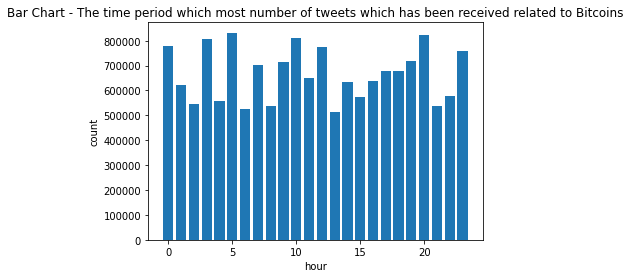

In [ ]:
#Analytic 1
#The time period which most number of tweets which has been received related to Bitcoins.

condition1 = (df_data.timestamp.isNotNull())


df2 = df_data.withColumn('hour', hour(df_data.timestamp))
df3 = df2.na.drop().groupBy("hour").count()
df3 = df3.selectExpr('hour as hour', 'count as _Count')

df4=df3.sort(desc("_count"))
df4.show(24)

xx = [obj for obj in df3.select('hour').collect()]

x = [obj.hour for obj in xx]
y = [int(i._Count) for i in df3.select('_Count').collect()]

plt.xlabel('hour')
plt.ylabel('count')
plt.title('Bar Chart - The time period which most number of tweets which has been received related to Bitcoins')
plt.bar(range(len(x)), y) 
plt.show()

# **Analytic** **2**

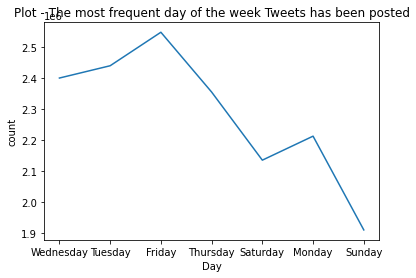

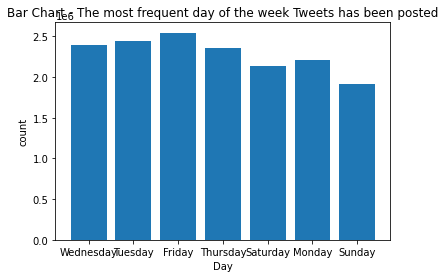

In [ ]:
#Analytic 2
#	The most frequent day of the week Tweets has been posted.

condition1 = (df_data.timestamp.isNotNull())

df_data.withColumn("timestamp",col("timestamp").cast("timestamp"))
df2 = df_data.withColumn('Day', F.date_format('timestamp', 'EEEE'))
df3 = df2.na.drop().groupBy("Day").count()
df3 = df3.selectExpr('Day as Day', 'count as _Count')

xx = [obj for obj in df3.select('Day').collect()]

x = [obj.Day for obj in xx]
y = [int(i._Count) for i in df3.select('_Count').collect()]

plt.xlabel('Day')
plt.ylabel('count')
plt.title('Plot - The most frequent day of the week Tweets has been posted')
plt.plot(x,y)
plt.show()

plt.xlabel('Day')
plt.ylabel('count')
plt.title('Bar Chart - The most frequent day of the week Tweets has been posted')
plt.bar(x,y)
plt.show()

# **Analytic** **3**

In [ ]:
#Analytic 3
#	Analyzing the content of the Tweet.

file = '/content/gdrive/MyDrive/BigData_Tweets/cleaned_tweets_file1.csv/part-00000-9825a4a9-2533-432a-b1ed-bc7064d277c0-c000.csv'
df = pd.read_csv(file,error_bad_lines=False,sep=',',nrows=1300)
print(df.head())

                    id  ...                                               text
0  1198266442673733633  ...                                               @btc
1  1198266441293860864  ...  Register now for the early access of the Codug...
2  1198266433471471617  ...  Daily profit for HODLING BTC since 2013 Data t...
3  1198266433941233664  ...  Bitcoin Suisse Certificates :) https://t.co/nd...
4  1198266427666505730  ...  The Worlds First Millennium Firm https://t.co/...

[5 rows x 8 columns]


b'Skipping line 18: expected 8 fields, saw 9\nSkipping line 42: expected 8 fields, saw 9\nSkipping line 215: expected 8 fields, saw 13\nSkipping line 260: expected 8 fields, saw 13\nSkipping line 473: expected 8 fields, saw 10\nSkipping line 596: expected 8 fields, saw 9\nSkipping line 918: expected 8 fields, saw 9\nSkipping line 1052: expected 8 fields, saw 11\n'


In [ ]:
df.shape

(1300, 8)

In [ ]:
data = df.drop(['replies','likes','retweets','id','user','fullname'],axis = 1)
data.reset_index(drop=True, inplace=True)
data.head()

,timestamp,text
0,2019-11-23T15:45:57.000Z,@btc
1,2019-11-23T15:45:56.000Z,Register now for the early access of the Codug...
2,2019-11-23T15:45:55.000Z,Daily profit for HODLING BTC since 2013 Data t...
3,2019-11-23T15:45:55.000Z,Bitcoin Suisse Certificates :) https://t.co/nd...
4,2019-11-23T15:45:53.000Z,The Worlds First Millennium Firm https://t.co/...


In [ ]:
tweets = data['text']
print(tweets[2])

Daily profit for HODLING BTC since 2013 Data taken since 29/10/2018 @ 10:45am (UTC) Updated every hour #bitcoin #btc #cryptocurrency #blockchain #cryptotrade #profit #digitalmine https://t.co/m09uOZS9aQ


In [ ]:
pip install whatthelang

     |████████████████████████████████| 788kB 9.3MB/s 
     |████████████████████████████████| 460kB 49.0MB/s 
     |████████████████████████████████| 245kB 48.3MB/s 
  Created wheel for whatthelang: filename=whatthelang-1.0.1-cp37-none-any.whl size=789821 sha256=c372c29194e2a59a0e43b05698a1cd86e59b223a7dff16cf93563a2ec73d3288
  Stored in directory: /root/.cache/pip/wheels/54/ec/de/379ea04fcc427c46fe3ecd21a5041875fcb41bbd81062abba5
  Created wheel for cysignals: filename=cysignals-1.10.3-cp37-cp37m-linux_x86_64.whl size=706044 sha256=726547272ecb294d23755515d548b6046ee7831349232102033d895e14bdaecd
  Stored in directory: /root/.cache/pip/wheels/1d/de/c9/22c3a5adc6ff0dd19904d4cab0677410e53f4fdd42188ae123
  Created wheel for pyfasttext: filename=pyfasttext-0.4.6-cp37-cp37m-linux_x86_64.whl size=1461227 sha256=d7533904854c034ae0872b01ba78c4b8004b27712d2e4e515721e0bcb76173e9
  Stored in directory: /root/.cache/pip/wheels/25/de/c6/3d26a304c069689a7bf5ef2cc774588663700c8381dbf3d947
Successful

In [ ]:
from whatthelang import WhatTheLang

wtl = WhatTheLang()
L=[]
for row in data['text']:
    if len(row)!=0:
        L.append(wtl.predict_lang(row))
    else:
        L.append(None)
        
data['lang'] = L
data.head()

,timestamp,text,lang
0,2019-11-23T15:45:57.000Z,@btc,CANT_PREDICT
1,2019-11-23T15:45:56.000Z,Register now for the early access of the Codug...,en
2,2019-11-23T15:45:55.000Z,Daily profit for HODLING BTC since 2013 Data t...,en
3,2019-11-23T15:45:55.000Z,Bitcoin Suisse Certificates :) https://t.co/nd...,en
4,2019-11-23T15:45:53.000Z,The Worlds First Millennium Firm https://t.co/...,en


In [ ]:
data = data[data["lang"] == 'en']
data.head()

,timestamp,text,lang
1,2019-11-23T15:45:56.000Z,Register now for the early access of the Codug...,en
2,2019-11-23T15:45:55.000Z,Daily profit for HODLING BTC since 2013 Data t...,en
3,2019-11-23T15:45:55.000Z,Bitcoin Suisse Certificates :) https://t.co/nd...,en
4,2019-11-23T15:45:53.000Z,The Worlds First Millennium Firm https://t.co/...,en
5,2019-11-23T15:45:52.000Z,@EarlofTyrone @wenlembo @coindesk @La__Cuen @H...,en


In [ ]:
import nltk
import re

from nltk.corpus import stopwords

nltk.download('stopwords')
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    text = ' '.join(text.split('.'))
    text = re.sub('\/',' ',text)
    text = text.strip('\'"')
    text = re.sub(r'@([^\s]+)',r'\1',text)
    text = re.sub(r'\\',' ',text)
    text = text.lower()
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'((http)\S+)','',text)
    text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
    text = [word for word in text.split() if word not in forbidden_words]
    return ' '.join(text)

data['text'] = data['text'].apply(lambda text: text_cleaning(text))
data.sample(3)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,timestamp,text,lang
854,2019-11-23T15:26:33.000Z,hr volume alert rlc current volume btc average...,en
420,2019-11-23T15:35:59.000Z,xrp btc fibonacci harmonic patterns co yqdslsq hn,en
1195,2019-11-23T15:18:49.000Z,activosdigitales empresa c cuta nortedesantand...,en


In [ ]:
from textblob import TextBlob

def sentiment(txt):
    return TextBlob(txt).sentiment.polarity

data['sentiment'] = data['text'].apply(lambda txt: sentiment(txt))      # new column of sentiment

data.head()

,timestamp,text,lang,sentiment
1,2019-11-23T15:45:56.000Z,register early access codugh api marketplace p...,en,0.100
2,2019-11-23T15:45:55.000Z,daily profit hodling btc since data taken sinc...,en,0.000
3,2019-11-23T15:45:55.000Z,bitcoin suisse certificates co ndabknotk,en,0.000
4,2019-11-23T15:45:53.000Z,worlds first millennium firm co lqgie akcz nas...,en,0.025
5,2019-11-23T15:45:52.000Z,earloftyrone wenlembo coindesk la cuen hameggs...,en,0.000


In [ ]:
data.to_csv('my_clean_tweets.csv', sep = ';',index = False)

tweets=pd.read_csv('my_clean_tweets.csv', sep=';')
tweets.sample(10)

,timestamp,text,lang,sentiment
735,2019-11-23T15:24:04.000Z,bitcoin price may hit k wear bulls peter brand...,en,0.000000
493,2019-11-23T15:30:13.000Z,bitcoin vision episode co ammx kkb via youtube,en,0.000000
211,2019-11-23T15:40:02.000Z,xmr worth btc,en,0.300000
634,2019-11-23T15:26:48.000Z,think bitcoin really feels empowering sense co...,en,0.200000
663,2019-11-23T15:26:04.000Z,new bitcoin report block transactions usd tota...,en,0.243182
320,2019-11-23T15:36:03.000Z,bitcoin price may hit k wear bulls peter brand...,en,0.000000
311,2019-11-23T15:36:23.000Z,iotex update iotex stable looks like going upt...,en,0.050000
453,2019-11-23T15:31:21.000Z,altseason coming altcoinbullish altcoin,en,0.000000
700,2019-11-23T15:25:05.000Z,live casino amp bet co ehukgipqcf,en,0.136364
107,2019-11-23T15:42:52.000Z,theeconomist setup free account co j f alxfqz,en,0.400000


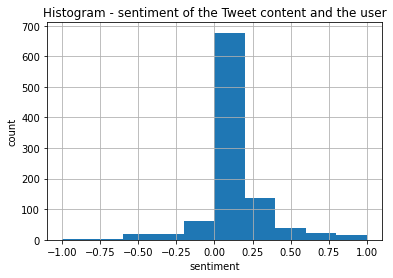

In [ ]:
plt.title('Histogram - sentiment of the Tweet content and the user')
plt.xlabel('sentiment')
plt.ylabel('count')

data['sentiment'].hist()

# **ANALYTIC 4**

In [ ]:
from functools import reduce
from pyspark.sql import DataFrame
def intersect(*dfs):
    return reduce(DataFrame.intersect, dfs)

In [ ]:
#Analytic 4
#Correlation between the user and the number of likes and the number of retweets.

df1 = df_data.drop('replies','timestamp','id','fullname')

df2=df1.na.drop(subset=["retweets"]).groupby('user').sum('retweets')
df3=df2.sort(desc('sum(retweets)'))
df3=df3.withColumnRenamed('sum(retweets)','Retweets')


In [ ]:
df5=df1.na.drop(subset=["likes"]).groupby("user").sum("likes")
df6=df5.sort(desc('sum(likes)'))
df7=df5.join(df2, on=['user'], how='inner').sort(desc('sum(likes)'))
df7 = df7.withColumnRenamed('sum(likes)', 'Likes')
df7 = df7.withColumnRenamed('sum(retweets)', 'Retweets')
df7.columns

['user', 'Likes', 'Retweets']

In [ ]:
df_part0 = df7.sort(desc('Likes')).limit(5)

In [ ]:
df_part0.show(5)

+--------------+-------+--------+
|          user|  Likes|Retweets|
+--------------+-------+--------+
|    APompliano|1533887|  345989|
|  Rhythmtrader| 742758|  179844|
|BelensayFinans| 714532|  566522|
|  ItsArabMoney| 291985|   61585|
|       netflix| 282959|   64013|
+--------------+-------+--------+



In [ ]:
df_part0.head(5)

[Row(user='APompliano', Likes=1533887, Retweets=345989),
 Row(user='Rhythmtrader', Likes=742758, Retweets=179844),
 Row(user='BelensayFinans', Likes=714532, Retweets=566522),
 Row(user='ItsArabMoney', Likes=291985, Retweets=61585),
 Row(user='netflix', Likes=282959, Retweets=64013)]

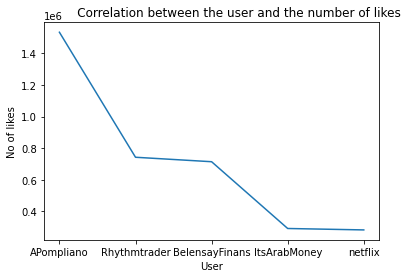

In [ ]:
from matplotlib import pyplot as plt
xx = [obj for obj in df_part0.select('user').collect()]
x = [obj.user for obj in xx]

y1 = [int(i.Likes) for i in df_part0.select('Likes').collect()]

# y1=df7.select('sum(likes)').collect()
plt.title('              Correlation between the user and the number of likes')
plt.xlabel('User')
plt.ylabel('No of likes')
plt.plot(x,y1)
plt.show()

#y2 = [int(i.Retweets) for i in df7.select('Retweets').collect()]

#plt.plot(x,y2)

#plt.show()

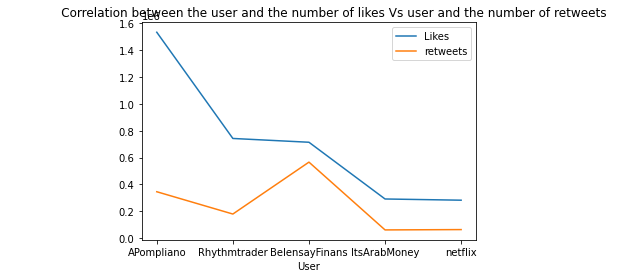

In [ ]:
from matplotlib import pyplot as plt
xx = [obj for obj in df_part0.select('user').collect()]
x = [obj.user for obj in xx]

y1 = [int(i.Likes) for i in df_part0.select('Likes').collect()]
y2 = [int(i.Retweets) for i in df_part0.select('Retweets').collect()]
# y1=df7.select('sum(likes)').collect()
plt.title('              Correlation between the user and the number of likes Vs user and the number of retweets ')
plt.xlabel('User')
plt.plot(x,y1,label='Likes')
plt.plot(x,y2,label='retweets')
plt.legend()
plt.show()


# **ANALYTIC 5**

In [ ]:
file = '/content/gdrive/MyDrive/BigData_Tweets/cleaned_tweets_file1.csv/part-00000-9825a4a9-2533-432a-b1ed-bc7064d277c0-c000.csv'
df_a5 = pd.read_csv(file,error_bad_lines=False,sep=',')
print(df_a5.head())

b'Skipping line 18: expected 8 fields, saw 9\nSkipping line 42: expected 8 fields, saw 9\nSkipping line 215: expected 8 fields, saw 13\nSkipping line 260: expected 8 fields, saw 13\nSkipping line 473: expected 8 fields, saw 10\nSkipping line 596: expected 8 fields, saw 9\nSkipping line 918: expected 8 fields, saw 9\nSkipping line 1052: expected 8 fields, saw 11\nSkipping line 1473: expected 8 fields, saw 9\nSkipping line 1475: expected 8 fields, saw 9\nSkipping line 1476: expected 8 fields, saw 9\nSkipping line 1915: expected 8 fields, saw 9\nSkipping line 1920: expected 8 fields, saw 9\nSkipping line 1922: expected 8 fields, saw 9\nSkipping line 1956: expected 8 fields, saw 9\nSkipping line 2023: expected 8 fields, saw 9\nSkipping line 2024: expected 8 fields, saw 9\nSkipping line 2240: expected 8 fields, saw 9\nSkipping line 2696: expected 8 fields, saw 10\nSkipping line 2822: expected 8 fields, saw 9\nSkipping line 2936: expected 8 fields, saw 10\nSkipping line 3299: expected 8 fiel

             id  ...                                               text
0  1.198266e+18  ...                                               @btc
1  1.198266e+18  ...  Register now for the early access of the Codug...
2  1.198266e+18  ...  Daily profit for HODLING BTC since 2013 Data t...
3  1.198266e+18  ...  Bitcoin Suisse Certificates :) https://t.co/nd...
4  1.198266e+18  ...  The Worlds First Millennium Firm https://t.co/...

[5 rows x 8 columns]


In [ ]:
df_a5.shape

(15973434, 8)

In [ ]:
df_a5.columns

Index(['id', 'user', 'fullname', 'timestamp', 'replies', 'likes', 'retweets',
       'text'],
      dtype='object')

In [ ]:
df_a5 = df_a5.drop(['replies','id','fullname','timestamp'],axis = 1)
df_a5.reset_index(drop=True, inplace=True)
df_a5.head()

,user,likes,retweets,text
0,Adekunl95628158,0,0,@btc
1,torusJKL,0,0,Register now for the early access of the Codug...
2,digital_mine_,0,0,Daily profit for HODLING BTC since 2013 Data t...
3,Vizique,0,0,Bitcoin Suisse Certificates :) https://t.co/nd...
4,theautomatski,0,0,The Worlds First Millennium Firm https://t.co/...


In [ ]:
df_a5.dtypes

user        object
likes       object
retweets    object
text        object
dtype: object

In [ ]:
#check the count of each column's null values 
df_a5.isnull().sum()

user          0
likes         0
retweets      0
text        764
dtype: int64

In [ ]:
#drop null values
df_a5 = df_a5.dropna(axis=0)

In [ ]:
# reset the indexes
df_a5.reset_index(drop=True, inplace=True)

In [ ]:
#check the count of each column's null values 
df_a5.isnull().sum()

user        0
likes       0
retweets    0
text        0
dtype: int64

In [ ]:
df_a5.columns

Index(['user', 'likes', 'retweets', 'text'], dtype='object')

In [ ]:
df_a5.dtypes

user        object
likes       object
retweets    object
text        object
dtype: object

In [ ]:
df_a5['likes'] = df_a5['likes'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

In [ ]:
df_a5.dtypes

user         object
likes       float64
retweets     object
text         object
dtype: object

In [ ]:
df_a5['retweets'] = df_a5['retweets'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

In [ ]:
df_a5.dtypes

user         object
likes       float64
retweets    float64
text         object
dtype: object

In [ ]:
new1=df_a5.groupby(['user'],as_index=False).max().reset_index(drop=True, inplace=False)
max = new1.sort_values(by=['retweets'], ascending=False)
max.head()

,user,likes,retweets,text
671973,TravWeav,58619.0,181240.0,"Bought 1,500 bitcoin in 2011 for $2.87 each. I..."
1244620,pulte,66922.0,178529.0,\The Random Bitcoin Recipient from Sept 28 is ...
1190119,netflix,282959.0,64013.0,FRIENDS 2018 PLOTLINES
324345,ItsArabMoney,291985.0,61585.0,The type of accidents I’m tryna make https://t...
878866,cryptomanran,109716.0,35284.0,“Bitcoin is fun but it’s a lot more fucking fu...


In [ ]:
max.columns

Index(['user', 'likes', 'retweets', 'text'], dtype='object')

In [ ]:
max.shape

(1432419, 4)

In [ ]:
retweets = max['text']
retweets

671973     Bought 1,500 bitcoin in 2011 for $2.87 each. I...
1244620    \The Random Bitcoin Recipient from Sept 28 is ...
1190119                               FRIENDS 2018 PLOTLINES
324345     The type of accidents I’m tryna make https://t...
878866     “Bitcoin is fun but it’s a lot more fucking fu...
                                 ...                        
538321     \"\n943399827144101888,WhalePanda,WhalePanda,2...
538320     Bitcoin’s price-to-earnings ratio metric prove...
538319                                   right time to buy ?
538318                                       Thank you Bybit
1432418    Best investment I’ve ever done has been with @...
Name: text, Length: 1432419, dtype: object

In [ ]:
max['text'] = max['text'].astype('string')

In [ ]:
max.dtypes

user         object
likes       float64
retweets    float64
text         string
dtype: object

In [ ]:
y = max.head(10000)

In [ ]:
y.head()

,user,likes,retweets,text
671973,TravWeav,58619.0,181240.0,"Bought 1,500 bitcoin in 2011 for $2.87 each. I..."
1244620,pulte,66922.0,178529.0,\The Random Bitcoin Recipient from Sept 28 is ...
1190119,netflix,282959.0,64013.0,FRIENDS 2018 PLOTLINES
324345,ItsArabMoney,291985.0,61585.0,The type of accidents I’m tryna make https://t...
878866,cryptomanran,109716.0,35284.0,“Bitcoin is fun but it’s a lot more fucking fu...


In [ ]:
y.shape

(10000, 4)

In [ ]:
from whatthelang import WhatTheLang

wtl = WhatTheLang()
L=[]
for row in y['text']:
    if len(row)!=0:
        L.append(wtl.predict_lang(row))
    else:
        L.append(None)
        
y['lang'] = L
y.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,user,likes,retweets,text,lang
671973,TravWeav,58619.0,181240.0,"Bought 1,500 bitcoin in 2011 for $2.87 each. I...",en
1244620,pulte,66922.0,178529.0,\The Random Bitcoin Recipient from Sept 28 is ...,en
1190119,netflix,282959.0,64013.0,FRIENDS 2018 PLOTLINES,da
324345,ItsArabMoney,291985.0,61585.0,The type of accidents I’m tryna make https://t...,en
878866,cryptomanran,109716.0,35284.0,“Bitcoin is fun but it’s a lot more fucking fu...,en


In [ ]:
ya = y[y["lang"] == 'en']
ya.head()

,user,likes,retweets,text,lang
671973,TravWeav,58619.0,181240.0,"Bought 1,500 bitcoin in 2011 for $2.87 each. I...",en
1244620,pulte,66922.0,178529.0,\The Random Bitcoin Recipient from Sept 28 is ...,en
324345,ItsArabMoney,291985.0,61585.0,The type of accidents I’m tryna make https://t...,en
878866,cryptomanran,109716.0,35284.0,“Bitcoin is fun but it’s a lot more fucking fu...,en
984358,guwop,138468.0,34318.0,if you lost money on bitcoin today target is g...,en


In [ ]:
ya.shape

(7342, 5)

In [ ]:
import nltk
import re

from nltk.corpus import stopwords

nltk.download('stopwords')
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    text = ' '.join(text.split('.'))
    text = re.sub('\/',' ',text)
    text = text.strip('\'"')
    text = re.sub(r'@([^\s]+)',r'\1',text)
    text = re.sub(r'\\',' ',text)
    text = text.lower()
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'((http)\S+)','',text)
    text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
    text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
    text = [word for word in text.split() if word not in forbidden_words]
    return ' '.join(text)

ya['text'] = ya['text'].apply(lambda text: text_cleaning(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def sentiment(txt):
    return TextBlob(txt).sentiment.polarity

ya['sentiment'] = ya['text'].apply(lambda txt: sentiment(txt))      # new column of sentiment

ya.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,user,likes,retweets,text,lang,sentiment
671973,TravWeav,58619.0,181240.0,bought bitcoin pick random people retweet give...,en,-0.5
1244620,pulte,66922.0,178529.0,random bitcoin recipient sept scott,en,-0.5
324345,ItsArabMoney,291985.0,61585.0,type accidents tryna make co z imfa,en,0.0
878866,cryptomanran,109716.0,35284.0,bitcoin fun lot fucking fun x leverage,en,0.3
984358,guwop,138468.0,34318.0,lost money bitcoin today target giving away gi...,en,0.2


In [ ]:
y_cluster = ya.drop(columns='user', axis=1)

In [ ]:
y_cluster = y_cluster.drop(columns='text', axis=1)

In [ ]:
y_cluster = y_cluster.drop(columns='lang', axis=1)

In [ ]:
y_cluster.columns

Index(['likes', 'retweets', 'sentiment'], dtype='object')

In [ ]:
y_cluster.shape

(7342, 3)

In [ ]:
y_cluster.dtypes

likes        float64
retweets     float64
sentiment    float64
dtype: object

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=8) 
kmeans.fit(y_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.cluster_centers_

array([[ 3.86691930e+02,  2.14317165e+02,  1.27549616e-01],
       [ 1.24875200e+05,  2.95940000e+04,  2.34666667e-01],
       [ 6.27705000e+04,  1.79884500e+05, -5.00000000e-01],
       [ 1.65954600e+04,  5.52362000e+03,  5.95606061e-02],
       [ 8.14787500e+04,  1.57472500e+04, -7.83333333e-02],
       [ 2.91985000e+05,  6.15850000e+04,  0.00000000e+00],
       [ 4.09391667e+04,  1.18515833e+04,  1.39614899e-01],
       [ 4.24213196e+03,  2.35939589e+03,  9.92346803e-02]])

In [ ]:
kmeans.n_iter_

9

In [ ]:
kmeans.labels_[:5]

array([2, 2, 3, 1, 1], dtype=int32)

In [ ]:
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(y_cluster)
        score = silhouette_score(y_cluster, kmeans.labels_)
        silhouette_coefficients.append(score)

In [ ]:
centroids = kmeans.cluster_centers_
print(centroids)

[[ 3.86691930e+02  2.14317165e+02  1.27549616e-01]
 [ 1.24875200e+05  2.95940000e+04  2.34666667e-01]
 [ 6.27705000e+04  1.79884500e+05 -5.00000000e-01]
 [ 1.65954600e+04  5.52362000e+03  5.95606061e-02]
 [ 8.14787500e+04  1.57472500e+04 -7.83333333e-02]
 [ 2.91985000e+05  6.15850000e+04  0.00000000e+00]
 [ 4.09391667e+04  1.18515833e+04  1.39614899e-01]
 [ 4.24213196e+03  2.35939589e+03  9.92346803e-02]]


In [ ]:
y_cluster.columns

Index(['likes', 'retweets', 'sentiment'], dtype='object')

In [ ]:
y_cluster.shape

(7342, 3)

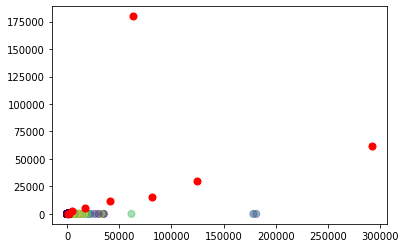

In [ ]:
plt.scatter(y_cluster['retweets'], y_cluster['sentiment'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

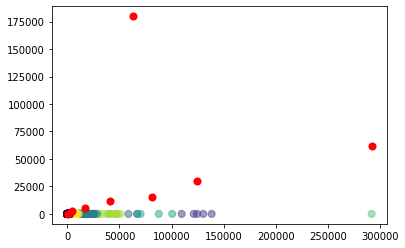

In [ ]:
plt.scatter(y_cluster['likes'], y_cluster['sentiment'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

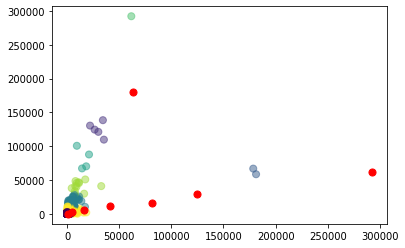

In [ ]:
plt.scatter(y_cluster['retweets'], y_cluster['likes'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

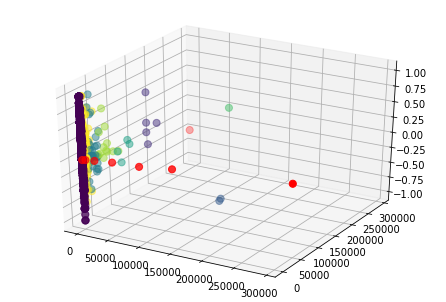

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(y_cluster['retweets'], y_cluster['likes'], y_cluster['sentiment'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

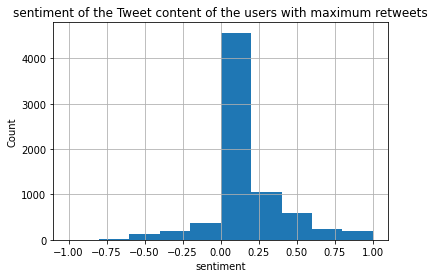

In [ ]:
plt.title('sentiment of the Tweet content of the users with maximum retweets')
plt.xlabel('sentiment')
plt.ylabel('Count')
ya['sentiment'].hist()

In [ ]:
ya.dtypes

user          object
likes        float64
retweets     float64
text          object
lang          object
sentiment    float64
dtype: object

In [ ]:
ya_neutral =ya[ya['sentiment'] == 0.0]
neutral=ya_neutral.head(10)
print("Before Shape:",ya.shape)
print("After Shape:",ya_neutral.shape)

Before Shape: (7342, 6)
After Shape: (3563, 6)


In [ ]:
neutral.shape

(10, 6)

In [ ]:
ya_positive =ya[ya['sentiment'] > 0.0]
positive=ya_positive.head(10)
print("Before Shape:",ya.shape)
print("After Shape:",ya_positive.shape)

Before Shape: (7342, 6)
After Shape: (3073, 6)


In [ ]:
ya_negative =ya[ya['sentiment'] < 0.0]
negative=ya_negative.head(10)
print("Before Shape:",ya.shape)
print("After Shape:",ya_negative.shape)

Before Shape: (7342, 6)
After Shape: (706, 6)


In [ ]:
ya_neutral.columns

Index(['user', 'likes', 'retweets', 'text', 'lang', 'sentiment'], dtype='object')

In [ ]:
negative_print=negative.copy()

In [ ]:
negative_print=negative_print.drop(columns=['text','lang'])

In [ ]:
neutral_print=neutral.copy()
neutral_print=neutral_print.drop(columns=['text','lang'])

In [ ]:
neutral_print.head()

,user,likes,retweets,sentiment
324345,ItsArabMoney,291985.0,61585.0,0.0
302532,HlGHKEYMOOD,87776.0,21015.0,0.0
355282,JonErlichman,50920.0,17410.0,0.0
707057,WolfOfCryptoSph,1956.0,15659.0,0.0
1095255,kucoincom,5575.0,13459.0,0.0


In [ ]:
positive_print=positive.copy()
positive_print=positive_print.drop(columns=['text','lang'])

In [ ]:
positive_print.head()

,user,likes,retweets,sentiment
878866,cryptomanran,109716.0,35284.0,0.300000
984358,guwop,138468.0,34318.0,0.200000
136825,CashApp,41091.0,32732.0,0.068182
141078,ChanceHarbour,124513.0,26413.0,0.723333
625098,StephenAtHome,130455.0,22002.0,0.050000


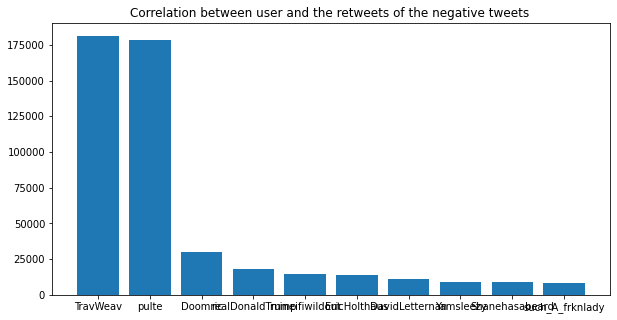

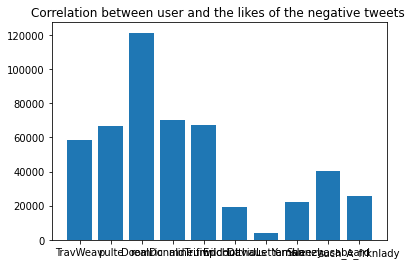

In [ ]:
# visualising- negative
plt.figure(figsize=(10, 5))

# Limiting the data set to 100 rows for more clearance
plt.bar(negative['user'],negative['retweets'])
plt.title('Correlation between user and the retweets of the negative tweets ')
plt.show()

plt.bar(negative['user'],negative['likes'])
plt.title('Correlation between user and the likes of the negative tweets ')
plt.show()

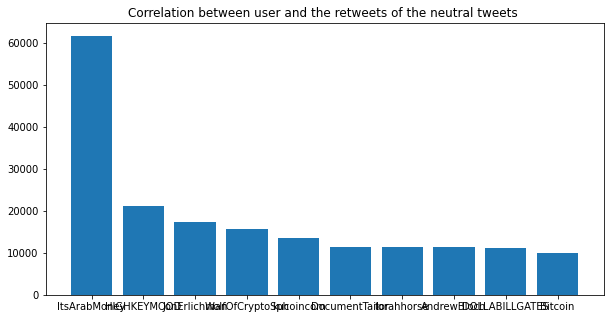

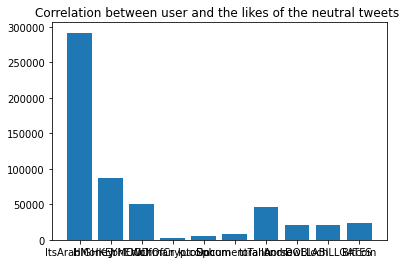

In [ ]:
# visualising-neutral
plt.figure(figsize=(10, 5))

# Limiting the data set to 100 rows for more clearance
plt.bar(neutral['user'],neutral['retweets'])
plt.title('Correlation between user and the retweets of the neutral tweets ')
plt.show()

plt.bar(neutral['user'],neutral['likes'])
plt.title('Correlation between user and the likes of the neutral tweets ')
plt.show()

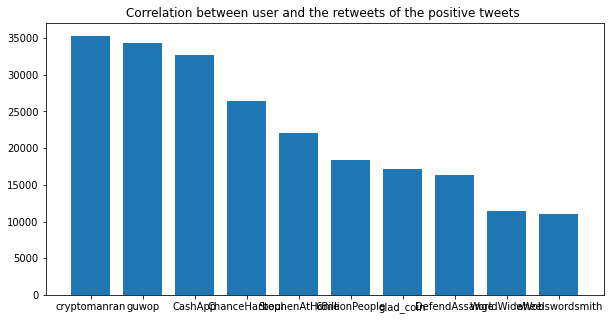

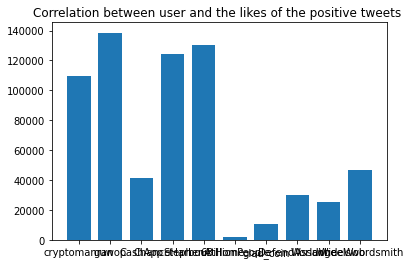

In [ ]:
# visualising-positive
plt.figure(figsize=(10, 5))
barWidth = 0.75
# Limiting the data set to 100 rows for more clearance
plt.bar(positive['user'],positive['retweets'] ,width=barWidth)
plt.title('Correlation between user and the retweets of the positive tweets ')
plt.show()

plt.bar(positive['user'],positive['likes'] ,width=barWidth)
plt.title('Correlation between user and the likes of the positive tweets ')
plt.show()

In [ ]:
ya.columns

Index(['user', 'likes', 'retweets', 'text', 'lang', 'sentiment'], dtype='object')

In [ ]:
ya1=ya.copy()
ya1=ya1.drop(columns=['user','text','lang'])

In [ ]:
ya1.columns

Index(['likes', 'retweets', 'sentiment'], dtype='object')

,likes,retweets,sentiment
likes,1.000000,0.545617,-0.027918
retweets,0.545617,1.000000,-0.043144
sentiment,-0.027918,-0.043144,1.000000


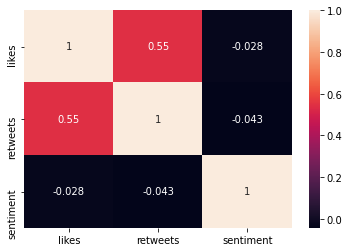

In [ ]:
# check the correlation

import seaborn as sns
sns.heatmap(ya1.corr(), annot=True)
ya1.corr()

,likes,retweets,sentiment
likes,1.000000,0.280201,0.197698
retweets,0.280201,1.000000,-0.713197
sentiment,0.197698,-0.713197,1.000000


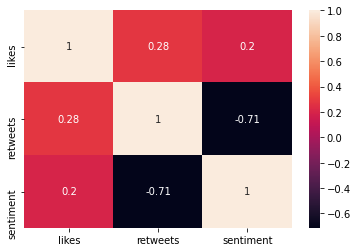

In [ ]:
import seaborn as sns

negative_corr=negative_print.copy()
negative_corr=negative_corr.drop(columns=['user'])

sns.heatmap(negative_corr.corr(), annot=True)
negative_corr.corr()

In [ ]:
neutral_print.head()

,user,likes,retweets,sentiment
324345,ItsArabMoney,291985.0,61585.0,0.0
302532,HlGHKEYMOOD,87776.0,21015.0,0.0
355282,JonErlichman,50920.0,17410.0,0.0
707057,WolfOfCryptoSph,1956.0,15659.0,0.0
1095255,kucoincom,5575.0,13459.0,0.0


,likes,retweets,sentiment
likes,1.000000,0.973847,NaN
retweets,0.973847,1.000000,NaN
sentiment,NaN,NaN,NaN


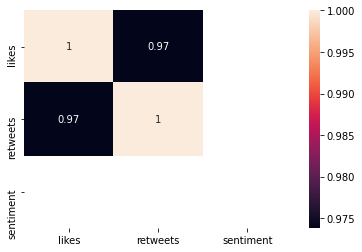

In [ ]:
import seaborn as sns

neutral_corr=neutral_print.copy()
neutral_corr=neutral_corr.drop(columns=['user'])

sns.heatmap(neutral_corr.corr(), annot=True)
neutral_corr.corr()

,likes,retweets,sentiment
likes,1.000000,0.633392,-0.184255
retweets,0.633392,1.000000,-0.109359
sentiment,-0.184255,-0.109359,1.000000


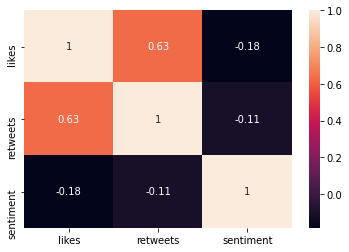

In [ ]:
import seaborn as sns

positive_corr=positive_print.copy()
positive_corr=positive_corr.drop(columns=['user'])

sns.heatmap(positive_corr.corr(), annot=True)
positive_corr.corr()

In [ ]:
df_copy = df_data.alias("df_copy") 

# **K Means Clustering**

In [ ]:
# vector assembler

from pyspark.ml.feature import VectorAssembler

df_copy.columns
assemble=VectorAssembler(inputCols=[
 'likes',
 'retweets'], outputCol='features')
assembled_data=assemble.transform(df_copy)
assembled_data.show()

+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+---------+
|                 id|           user|            fullname|          timestamp|replies|likes|retweets|                                 text| features|
+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+---------+
|1198266442673733633|Adekunl95628158|     Adekunle Daniel|2019-11-23 15:45:57|      0|    0|       0|                                @btc |(2,[],[])|
|1198266441293860864|       torusJKL|Gal Buki ($torusJKL)|2019-11-23 15:45:56|      0|    0|       0|                 Register now for ...|(2,[],[])|
|1198266433471471617|  digital_mine_|digital mine ⚡🤖?...|2019-11-23 15:45:55|      0|    0|       0|                 Daily profit for ...|(2,[],[])|
|1198266433941233664|        Vizique|             Vizique|2019-11-23 15:45:55|      0|    0|       0|

In [ ]:
assembled_data.dtypes

[('id', 'string'),
 ('user', 'string'),
 ('fullname', 'string'),
 ('timestamp', 'timestamp'),
 ('replies', 'string'),
 ('likes', 'int'),
 ('retweets', 'int'),
 ('text', 'string'),
 ('features', 'vector')]

In [ ]:
# fit the K means model

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=10, seed=1)  # 10 clusters here
model = kmeans.fit(assembled_data.select('features'))

In [ ]:
# transform the initial dataframe to include cluster assignments

transformed = model.transform(assembled_data)
transformed.show()    

+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+---------+----------+
|                 id|           user|            fullname|          timestamp|replies|likes|retweets|                                 text| features|prediction|
+-------------------+---------------+--------------------+-------------------+-------+-----+--------+-------------------------------------+---------+----------+
|1198266442673733633|Adekunl95628158|     Adekunle Daniel|2019-11-23 15:45:57|      0|    0|       0|                                @btc |(2,[],[])|         0|
|1198266441293860864|       torusJKL|Gal Buki ($torusJKL)|2019-11-23 15:45:56|      0|    0|       0|                 Register now for ...|(2,[],[])|         0|
|1198266433471471617|  digital_mine_|digital mine ⚡🤖?...|2019-11-23 15:45:55|      0|    0|       0|                 Daily profit for ...|(2,[],[])|         0|
|1198266433941233664|        Viziqu

In [ ]:
# Evaluate clustering by computing Silhouette score

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9972514471442407


In [ ]:
# Shows the result

print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[1.32995552 0.54516112]
[287472.  62799.]
[ 56588.75 151868.25]
[120834.16666667  26222.16666667]
[40025.71428571 10992.21428571]
[1958.16803279  629.84460383]
[414.95577438 141.33633738]
[5579.46028037 2787.57242991]
[75095.33333333 17875.33333333]
[17504.63492063  5569.66666667]


In [ ]:
transformed.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         6|
|         3|
|         5|
|         9|
|         4|
|         8|
|         7|
|         2|
|         0|
+----------+



In [ ]:
print(kmeans.predictionCol)

KMeans_82c1201d4d07__predictionCol


In [ ]:
print((transformed.count(), len(transformed.columns)))

(15996363, 10)


In [ ]:
# Filtering

filtered_1 = transformed.where(transformed.prediction==0)
print((filtered_1.count(), len(filtered_1.columns)))

filtered_2 = transformed.where(transformed.prediction==1)
print((filtered_2.count(), len(filtered_2.columns)))

filtered_3 = transformed.where(transformed.prediction==2)
print((filtered_3.count(), len(filtered_3.columns)))

filtered_4 = transformed.where(transformed.prediction==3)
print((filtered_4.count(), len(filtered_4.columns)))

filtered_5 = transformed.where(transformed.prediction==4)
print((filtered_5.count(), len(filtered_5.columns)))

filtered_6 = transformed.where(transformed.prediction==5)
print((filtered_6.count(), len(filtered_6.columns)))

filtered_7 = transformed.where(transformed.prediction==6)
print((filtered_7.count(), len(filtered_7.columns)))

filtered_8 = transformed.where(transformed.prediction==7)
print((filtered_8.count(), len(filtered_8.columns)))

filtered_9 = transformed.where(transformed.prediction==8)
print((filtered_9.count(), len(filtered_9.columns)))

filtered_10 = transformed.where(transformed.prediction==9)
print((filtered_10.count(), len(filtered_10.columns)))

(15964082, 10)
(2, 10)
(4, 10)
(6, 10)
(14, 10)
(2935, 10)
(28825, 10)
(429, 10)
(3, 10)
(63, 10)


In [ ]:
# Visualizing 

import matplotlib.pyplot as plt

df_handy1 = filtered_1.toHandy()
df_handy2 = filtered_2.toHandy()
df_handy3 = filtered_3.toHandy()
df_handy4 = filtered_4.toHandy()
df_handy5 = filtered_5.toHandy()
df_handy6 = filtered_6.toHandy()
df_handy7 = filtered_7.toHandy()
df_handy8 = filtered_8.toHandy()
df_handy9 = filtered_9.toHandy()
df_handy10 = filtered_10.toHandy()



In [ ]:
transformed.dtypes

[('id', 'string'),
 ('user', 'string'),
 ('fullname', 'string'),
 ('timestamp', 'timestamp'),
 ('replies', 'string'),
 ('likes', 'int'),
 ('retweets', 'int'),
 ('text', 'string'),
 ('features', 'vector'),
 ('prediction', 'int')]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])

ax.scatter(transformed.columns['retweets'], transformed.columns['likes'], c= transformed.columns['prediction'], s=50, alpha=0.5)
ax.scatter(center[:, 0], center[:, 1], c='red', s=50)
plt.show()

In [ ]:
centers

[array([1.32995552, 0.54516112]),
 array([287472.,  62799.]),
 array([ 56588.75, 151868.25]),
 array([120834.16666667,  26222.16666667]),
 array([40025.71428571, 10992.21428571]),
 array([1958.16803279,  629.84460383]),
 array([414.95577438, 141.33633738]),
 array([5579.46028037, 2787.57242991]),
 array([75095.33333333, 17875.33333333]),
 array([17504.63492063,  5569.66666667])]

In [ ]:
centers[0]

array([1.32995552, 0.54516112])

In [ ]:
# Plotting the results

df_handy1.cols[['retweets','likes']].scatterplot()


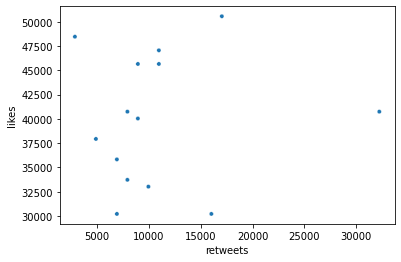

In [ ]:
df_handy2.cols[['retweets','likes']].scatterplot()


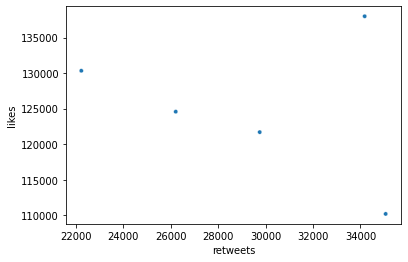

In [ ]:
df_handy3.cols[['retweets','likes']].scatterplot()


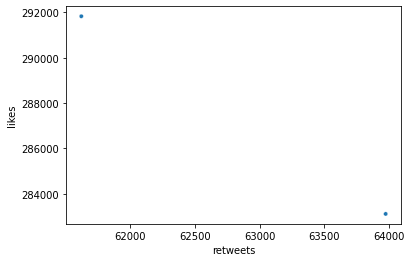

In [ ]:
df_handy4.cols[['retweets','likes']].scatterplot()

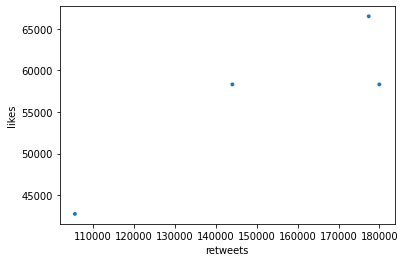

In [ ]:
df_handy5.cols[['retweets','likes']].scatterplot()

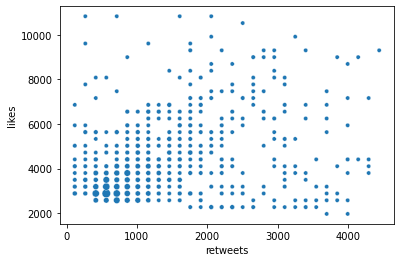

In [ ]:
df_handy6.cols[['retweets','likes']].scatterplot()


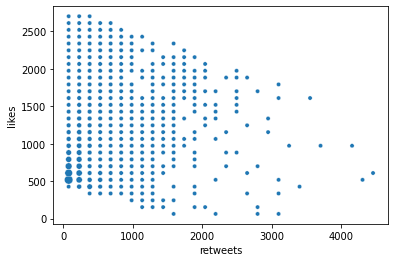

In [ ]:
df_handy7.cols[['retweets','likes']].scatterplot()


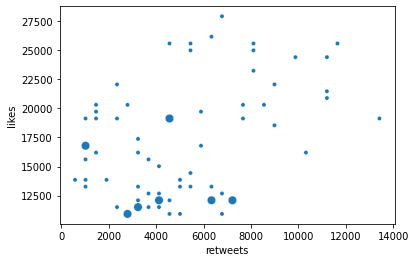

In [ ]:
df_handy8.cols[['retweets','likes']].scatterplot()


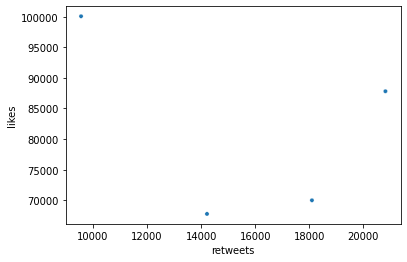

In [ ]:
df_handy9.cols[['retweets','likes']].scatterplot()


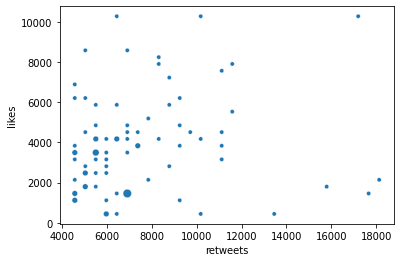

In [ ]:
df_handy10.cols[['retweets','likes']].scatterplot()